In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import glob
import cv2 as cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, CategoricalAccuracy

# Constants

In [2]:
BATCH_SIZE = 32
DIM = 256
CONV_BASE_FILTERS = 16

# Data processing

In [3]:
path = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

In [4]:
masks = glob.glob(path + '*/*_mask.tif*')

images = []
abnormalities = []

for mask in tqdm(masks):
    images.append(mask[:-9]+'.tif')
    if np.max(cv2.imread(mask)) > 0:
        abnormalities.append(1)
    else:
        abnormalities.append(0)

print('\n Check if the lists are correctly built ...\n')
print('Amount of \n - images : {}\n - masks: {}\n - abnormalities: {} \n'.format(len(images), len(masks), len(abnormalities)))
print('Type in the lists of \n - images : {}\n - masks: {}\n - abnormalities: {} \n'.format(type(images[0]), type(masks[0]), type(abnormalities[0])))

100%|██████████| 3929/3929 [00:26<00:00, 148.84it/s]


 Check if the lists are correctly built ...

Amount of 
 - images : 3929
 - masks: 3929
 - abnormalities: 3929 

Type in the lists of 
 - images : <class 'str'>
 - masks: <class 'str'>
 - abnormalities: <class 'int'> 



In [5]:
paths = pd.DataFrame({'image': images,'mask': masks,'abnormality': abnormalities})

paths.head()

,image,mask,abnormality
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


# Data analysis

In [6]:
train, test = train_test_split(paths, stratify=paths['abnormality'], test_size=0.15, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train, validation = train_test_split(paths, stratify=paths['abnormality'], test_size=0.1, random_state=0)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

print('Amount of samples used for : \n - training : {}\n - validation : {}\n - testing : {}'.format(train.shape[0], validation.shape[0], test.shape[0]))

Amount of samples used for : 
 - training : 3536
 - validation : 393
 - testing : 590


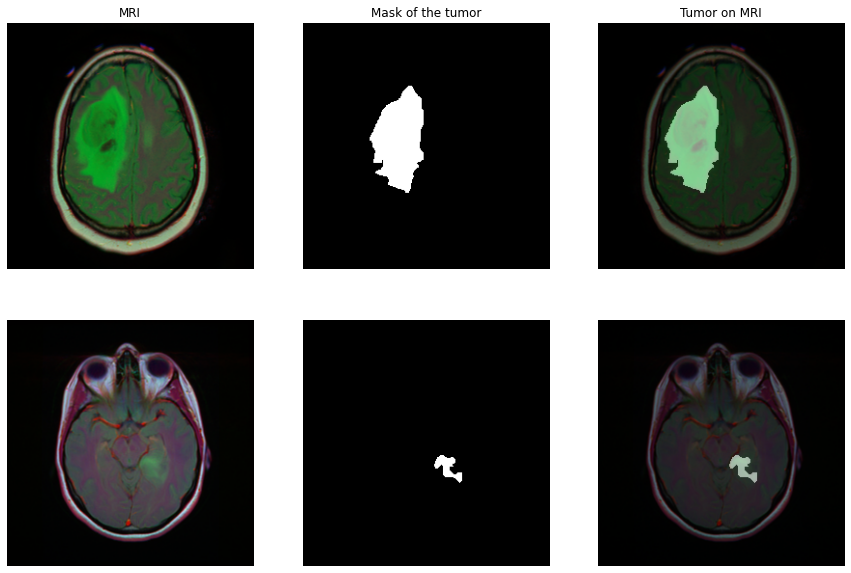

In [7]:
SAMPLES_TO_OBSERVE = 2

random_with_abnormality = paths[paths['abnormality']==1].sample(SAMPLES_TO_OBSERVE)

f, ax = plt.subplots(SAMPLES_TO_OBSERVE,3, figsize=(15,10))
[axi.set_axis_off() for axi in ax.ravel()]
for i in range(SAMPLES_TO_OBSERVE):
    img = cv2.imread(random_with_abnormality.iloc[i]['image'])
    msk = cv2.imread(random_with_abnormality.iloc[i]['mask'])
    blend = cv2.addWeighted(img, 0.5, msk, 0.5, 0.)
    ax[i,0].imshow(img)
    ax[i,1].imshow(msk)
    ax[i,2].imshow(blend)
    if i==0:
        ax[i,0].set_title('MRI')
        ax[i,1].set_title('Mask of the tumor')
        ax[i,2].set_title('Tumor on MRI')

# Build custom loss : weighted BCE

In [8]:
train_with_abnormality = train[train['abnormality']==1]
train_with_abnormality = train_with_abnormality.reset_index(drop=True)

s = 0
tot = 0
for index in tqdm(train_with_abnormality.index):
    msk = cv2.imread(train_with_abnormality['mask'].iloc[index])
    msk_flat = np.reshape(msk,-1)
    s+=np.sum(msk_flat)/255.
    tot+=msk_flat.shape[0]

one_weight = 1-s/tot
zero_weight = 1-one_weight

print('Fraction of : \n - ones : {}\n - zeros: {}\n --------- \n'.format(one_weight, zero_weight))

100%|██████████| 1236/1236 [00:01<00:00, 882.66it/s]

Fraction of : 
 - ones : 0.9707075446168968
 - zeros: 0.02929245538310321
 --------- 



In [9]:
msk1 = cv2.imread(train_with_abnormality['mask'].iloc[0], cv2.IMREAD_GRAYSCALE)
msk1 = msk1/255.
msk2 = cv2.imread(train_with_abnormality['mask'].iloc[89], cv2.IMREAD_GRAYSCALE)
msk2 = msk2/255.
msk3 = np.zeros(shape=(256,256))

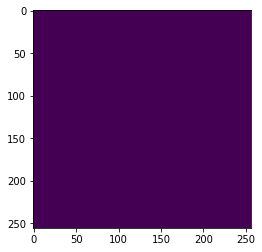

In [10]:
plt.imshow(msk3)

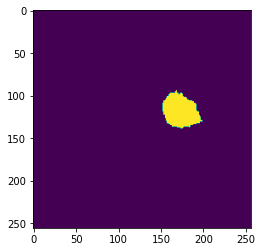

In [11]:
plt.imshow(msk2)

In [12]:
class WeightedBinaryCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, weight,name='weighted_binary_crossentropy'):
        super().__init__(name=name)
        self.weight = weight

    def call(self, y_true, y_pred):
        bce = tf.losses.binary_crossentropy(y_true, y_pred)[:,None]
        bce = bce*(1-y_true) + self.weight*bce*(y_true)
        return bce

In [13]:
bce = tf.keras.losses.BinaryCrossentropy()
wBCE = WeightedBinaryCrossEntropy(one_weight)
print('\n Results for loss btw msk1 and msk2 : \n - BCE : {}\n - BCE with sample_weight : {} \n - custom wBCE : {} \n'.format(bce(msk1,msk2),bce(msk1,msk2,sample_weight=one_weight),wBCE(msk1,msk2)))
print('\n Results for loss btw msk1 and msk3 : \n - BCE : {}\n - BCE with sample_weight : {} \n - custom wBCE : {} \n'.format(bce(msk1,msk3),bce(msk1,msk3,sample_weight=one_weight),wBCE(msk1,msk3)))
print('\n Results for loss btw msk2 and msk3 : \n - BCE : {}\n - BCE with sample_weight : {} \n - custom wBCE : {} \n'.format(bce(msk2,msk3),bce(msk2,msk3,sample_weight=one_weight),wBCE(msk2,msk3)))

2022-01-30 11:47:18.663619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 11:47:18.771666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 11:47:18.772411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



 Results for loss btw msk1 and msk2 : 
 - BCE : 0.45613935589790344
 - BCE with sample_weight : 0.4427779018878937 
 - custom wBCE : 0.4550110697746277 


 Results for loss btw msk1 and msk3 : 
 - BCE : 0.3699953854084015
 - BCE with sample_weight : 0.3591573238372803 
 - custom wBCE : 0.3684684932231903 


 Results for loss btw msk2 and msk3 : 
 - BCE : 0.32668808102607727
 - BCE with sample_weight : 0.3171185553073883 
 - custom wBCE : 0.3253278136253357 



2022-01-30 11:47:18.775665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-30 11:47:18.776688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 11:47:18.777471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 11:47:18.778187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

# Data Generator

In [14]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, dataframe, batch_size, dim, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.dim = dim
        self.indices = self.dataframe.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, list_IDs_temp):
        batch_images = np.empty((self.batch_size, self.dim, self.dim, 3))
        batch_masks = np.empty((self.batch_size, self.dim, self.dim, 1))
        for i,_id in enumerate(list_IDs_temp):
            img = cv2.imread(self.dataframe.iloc[_id]['image'])
            img = img/255.
            if self.dim!=img.shape[1]:
                img = cv2.resize(img, (self.dim, self.dim), interpolation= cv2.INTER_LINEAR)
            batch_images[i]=img
            
            msk = cv2.imread(self.dataframe.iloc[_id]['mask'], cv2.IMREAD_GRAYSCALE)
            msk = msk/255.
            if self.dim!=msk.shape[1]:
                msk = cv2.resize(msk, (self.dim, self.dim), interpolation= cv2.INTER_LINEAR)
            msk = np.expand_dims(msk, axis=-1)
            batch_masks[i]=msk
        return batch_images,batch_masks

In [15]:
train_generator = DataGenerator(train, BATCH_SIZE, DIM)
validation_generator = DataGenerator(validation, BATCH_SIZE, DIM)

# UNet : construction

In [16]:
def DoubleConv2D(input_tensor, filters, kernel_size):
    
    x = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def EncoderCell(input_tensor, filters, dropout_rate, kernel_size):

    conv_output = DoubleConv2D(input_tensor, filters, kernel_size)
    pool_output = MaxPool2D((2, 2))(conv_output)
    pool_output = Dropout(dropout_rate)(pool_output)

    return conv_output, pool_output

def DecoderCell(VerticalConvInput, HorizontalConvInput, filters, dropout_rate, kernel_size):

    x = Conv2DTranspose(filters, kernel_size, strides = (2, 2), padding = 'same')(VerticalConvInput)
    x = Concatenate()([x, HorizontalConvInput])
    x = Dropout(dropout_rate)(x)
    VerticalConvOutput = DoubleConv2D(x, filters, kernel_size = 3)

    return VerticalConvOutput
  
def UNet(input_shape, n_filters = 16, dropout_rate = 0.1):

    inputs = Input(input_shape)

    conv_output1, pooling_output1 = EncoderCell(inputs, filters = n_filters * 1, kernel_size = 3, dropout_rate = dropout_rate)

    conv_output2, pooling_output2 = EncoderCell(pooling_output1, filters = n_filters * 2, kernel_size = 3, dropout_rate = dropout_rate)
    
    conv_output3, pooling_output3 = EncoderCell(pooling_output2, filters = n_filters * 4, kernel_size = 3, dropout_rate = dropout_rate)

    conv_output4, pooling_output4 = EncoderCell(pooling_output3, filters = n_filters * 8, kernel_size = 3, dropout_rate = dropout_rate)
    
    conv_output5 = DoubleConv2D(pooling_output4, filters = n_filters * 16, kernel_size = 3)
    
    conv_output6 = DecoderCell(conv_output5, conv_output4, filters = n_filters * 8, kernel_size = 3, dropout_rate = dropout_rate)

    conv_output7 = DecoderCell(conv_output6, conv_output3, filters = n_filters * 4, kernel_size = 3, dropout_rate = dropout_rate)
    
    conv_output8 = DecoderCell(conv_output7, conv_output2, filters = n_filters * 2, kernel_size = 3, dropout_rate = dropout_rate)

    conv_output9 = DecoderCell(conv_output8, conv_output1, filters = n_filters * 1, kernel_size = 3, dropout_rate = dropout_rate)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv_output9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# UNet : training

In [17]:
model = UNet((DIM,DIM,3), n_filters=CONV_BASE_FILTERS, dropout_rate=0.05)
model.compile(optimizer=Adam(), loss=wBCE, metrics=[MeanIoU(num_classes=2)])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('unet-brain-mri-weighted-bce.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
results = model.fit(train_generator, epochs=50, callbacks=callbacks, validation_data = validation_generator)

2022-01-30 11:47:22.025480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-30 11:47:25.921161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 [==============================] - 62s 473ms/step - loss: 0.2611 - mean_io_u: 0.4949 - val_loss: 0.2156 - val_mean_io_u: 0.4947

Epoch 00001: val_loss improved from inf to 0.21561, saving model to unet-brain-mri-weighted-bce.h5
Epoch 2/50
110/110 [==============================] - 38s 342ms/step - loss: 0.1049 - mean_io_u: 0.4949 - val_loss: 0.0740 - val_mean_io_u: 0.4947

Epoch 00002: val_loss improved from 0.21561 to 0.07400, saving model to unet-brain-mri-weighted-bce.h5
Epoch 3/50
110/110 [==============================] - 37s 340ms/step - loss: 0.0636 - mean_io_u: 0.4949 - val_loss: 0.0562 - val_mean_io_u: 0.4945

Epoch 00003: val_loss improved from 0.07400 to 0.05618, saving model to unet-brain-mri-weighted-bce.h5
Epoch 4/50
110/110 [==============================] - 37s 340ms/step - loss: 0.0429 - mean_io_u: 0.4949 - val_loss: 0.0401 - val_mean_io_u: 0.4948

Epoch 00004: val_loss improved from 0.05618 to 0.04013, saving model to unet-brain-mri-weighted-bce.h5
Epoch 5/50


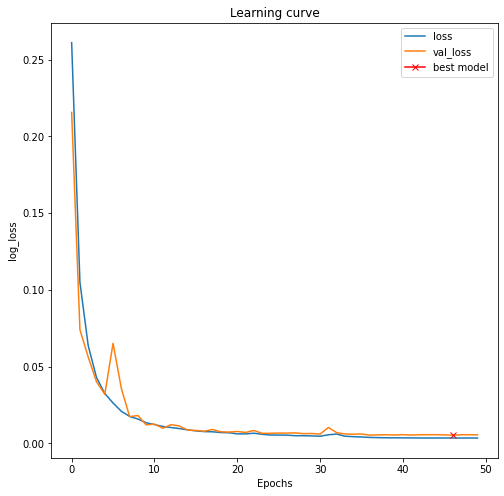

In [21]:
plt.figure(figsize=(8, 8))
plt.title('Learning curve')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.plot( np.argmin(results.history['val_loss']), np.min(results.history['val_loss']), marker='x', color='r', label='best model')
plt.xlabel('Epochs')
plt.ylabel('log_loss')
plt.legend()

# Results analysis

In [22]:
test_with_abnormality = test[test['abnormality']==1]
test_with_abnormality = test_with_abnormality.reset_index(drop=True)

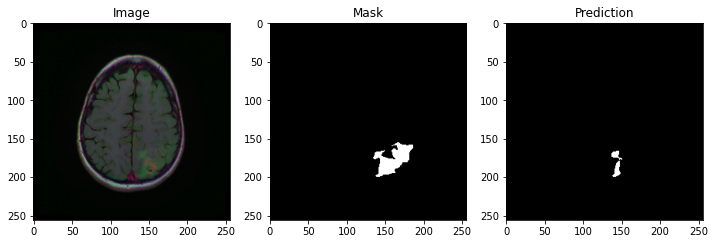

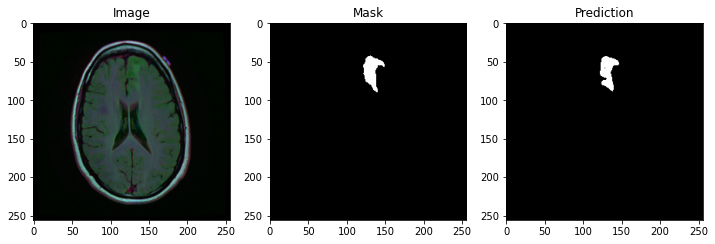

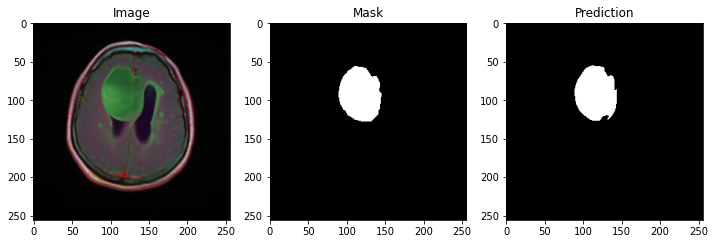

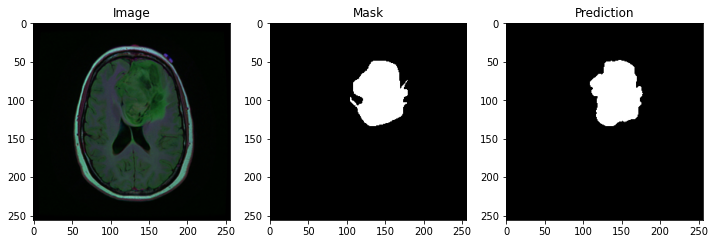

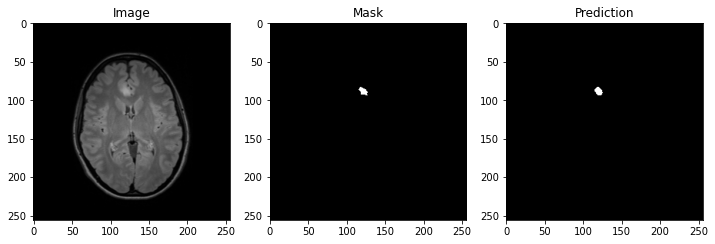

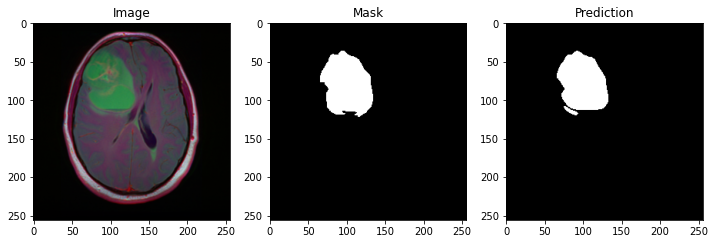

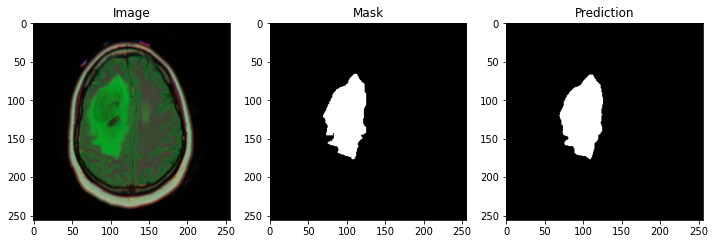

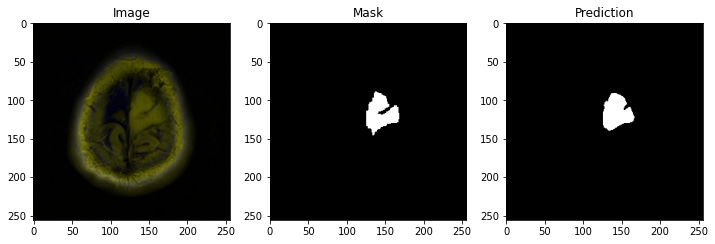

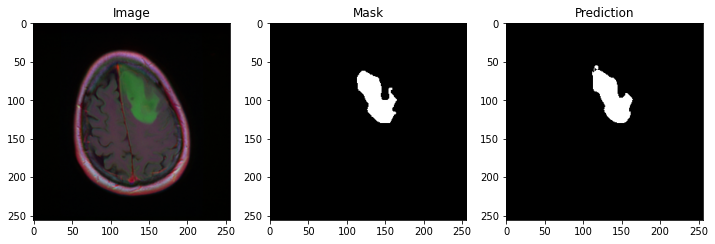

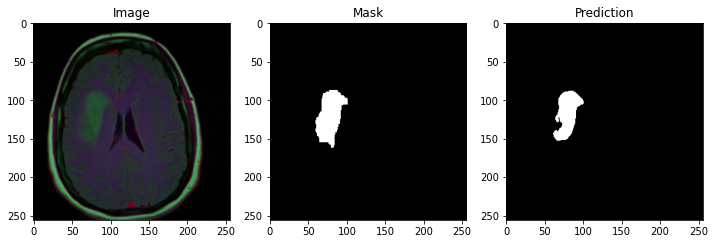

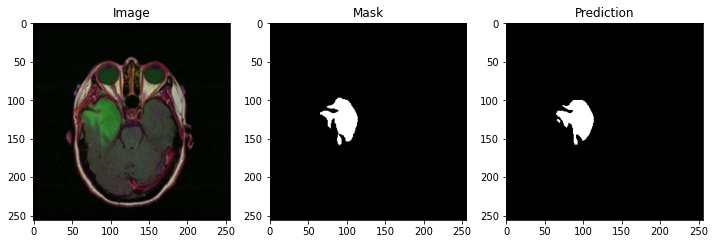

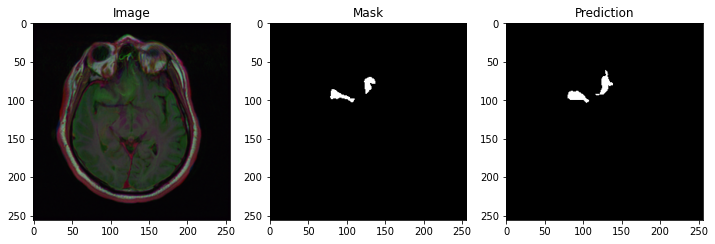

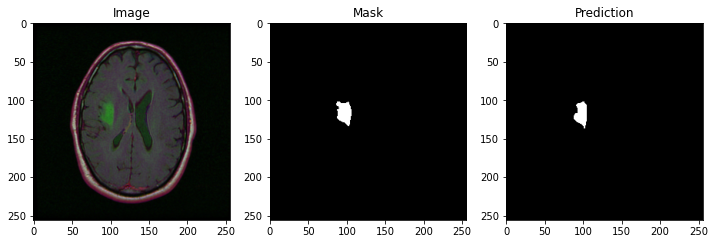

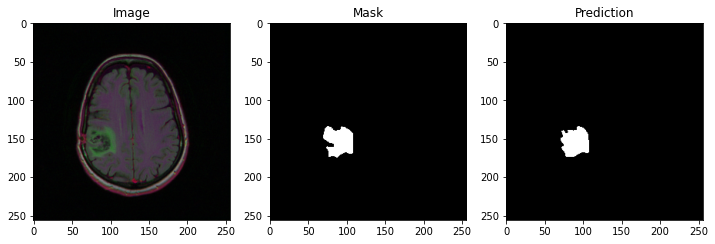

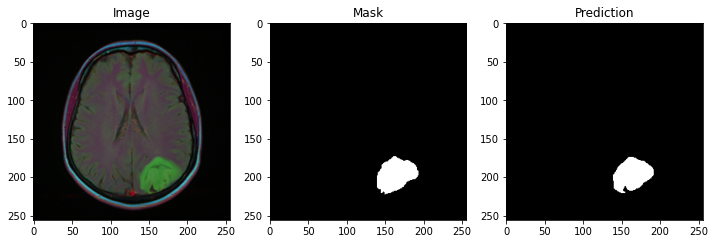

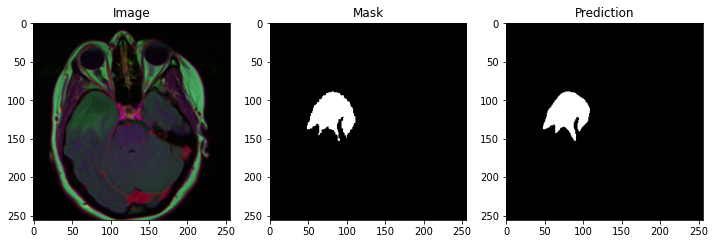

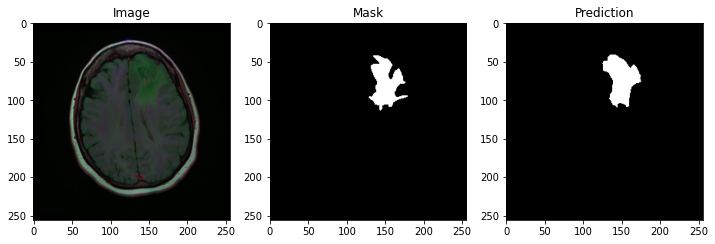

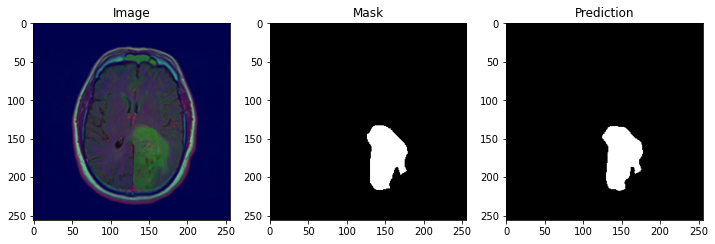

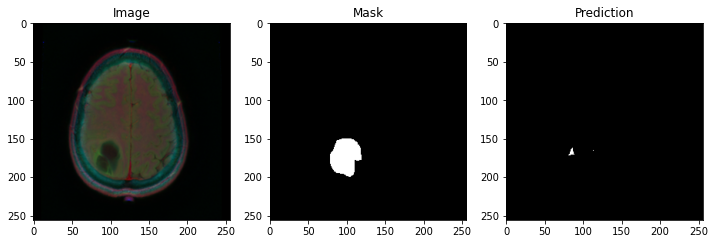

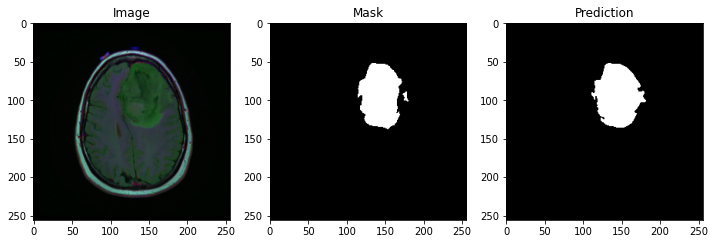

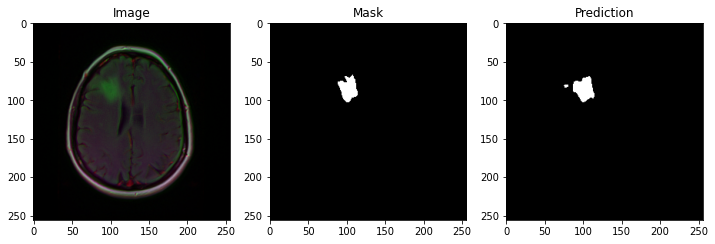

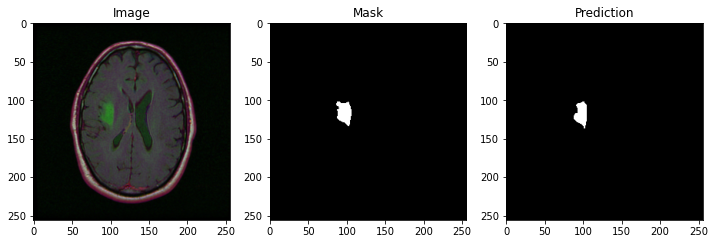

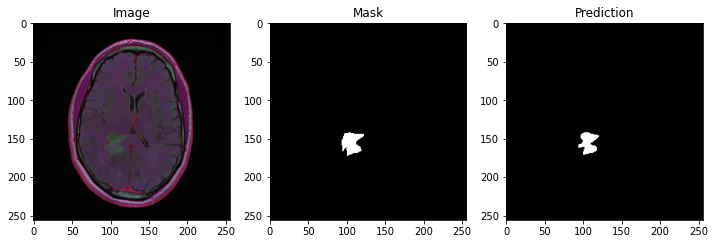

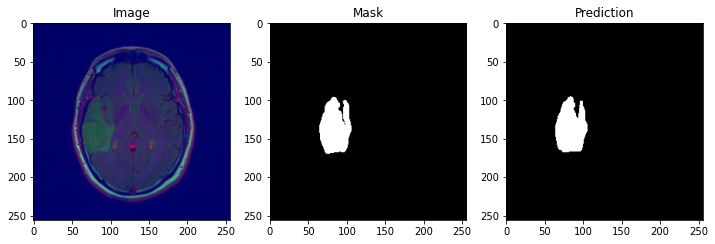

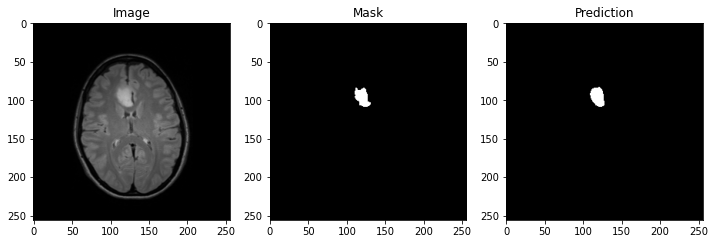

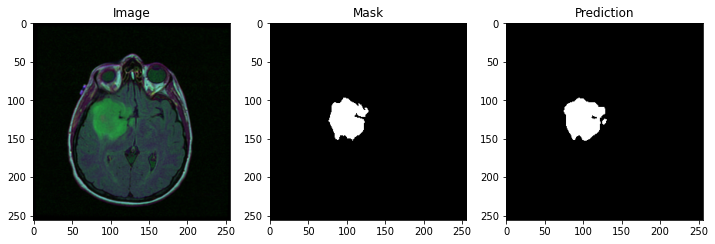

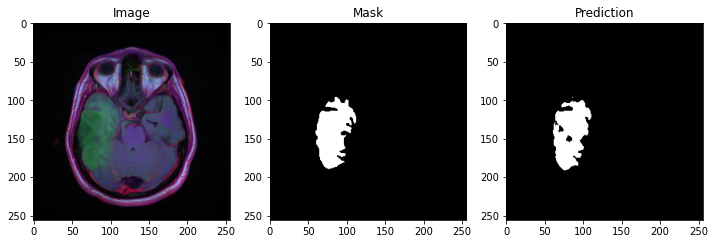

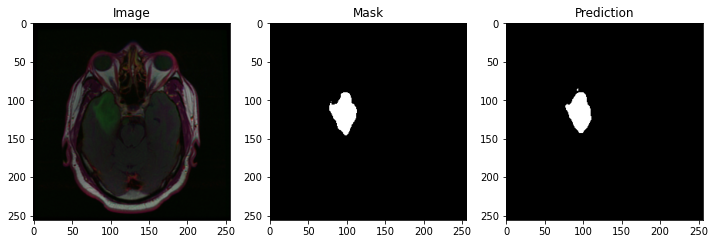

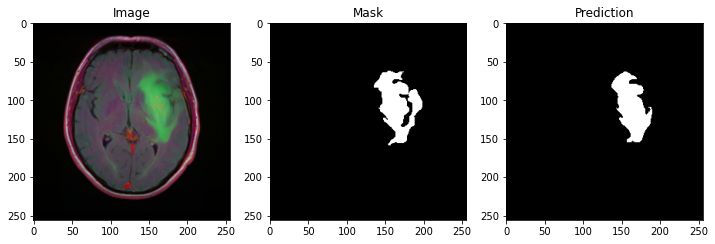

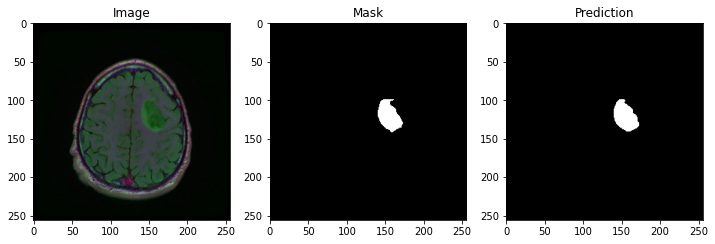

In [23]:
for i in range(30):
    index=np.random.randint(1,len(test_with_abnormality.index))
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()

In [24]:
scores = []

for index in tqdm(test_with_abnormality.index):
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    msk = cv2.imread(test_with_abnormality['mask'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.expand_dims(pred, axis=-1)
    intersection = np.logical_and(msk, pred)
    union = np.logical_or(msk, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    scores.append(iou_score)

print('Mean IoU score on the test dataset is {:#.3g} .'.format(sum(scores)/len(scores)))

100%|██████████| 206/206 [01:11<00:00,  2.89it/s]

Mean IoU score on the test dataset is 0.0305 .


In [25]:
scores

[0.0075225830078125,
 0.035247802734375,
 0.0497283935546875,
 0.02947998046875,
 0.0023651123046875,
 0.0152740478515625,
 0.0208892822265625,
 0.0637054443359375,
 0.010650634765625,
 0.00299072265625,
 0.0138702392578125,
 0.000732421875,
 0.0364990234375,
 0.016448974609375,
 0.015625,
 0.0567169189453125,
 0.02197265625,
 0.01055908203125,
 0.0428314208984375,
 0.018890380859375,
 0.044952392578125,
 0.0825653076171875,
 0.00640869140625,
 0.018341064453125,
 0.0087127685546875,
 0.03717041015625,
 0.0365753173828125,
 0.0004119873046875,
 0.013763427734375,
 0.0374298095703125,
 0.00897216796875,
 0.038909912109375,
 0.0289764404296875,
 0.0009002685546875,
 0.005218505859375,
 0.045806884765625,
 0.009033203125,
 0.0642852783203125,
 0.0617523193359375,
 0.004486083984375,
 0.0108642578125,
 0.0622406005859375,
 0.040374755859375,
 0.067169189453125,
 0.0171966552734375,
 0.0472564697265625,
 0.0211944580078125,
 0.0584869384765625,
 0.030120849609375,
 0.00506591796875,
 0.0087

In [26]:
for index in [index for index in range(len(scores)) if scores[index]==0.]:
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()

In [27]:
sorted(scores)[-1:-15:-1]

[0.1059722900390625,
 0.09649658203125,
 0.09356689453125,
 0.0894012451171875,
 0.085968017578125,
 0.0858001708984375,
 0.0836639404296875,
 0.0825653076171875,
 0.07757568359375,
 0.0774688720703125,
 0.0774688720703125,
 0.0772857666015625,
 0.0753173828125,
 0.0721282958984375]

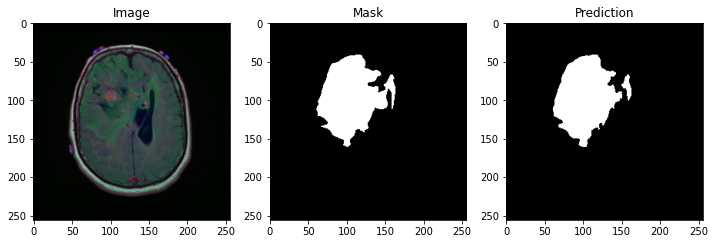

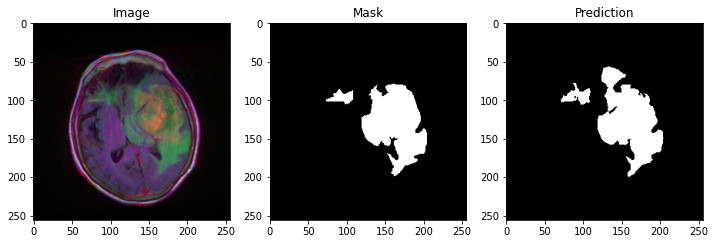

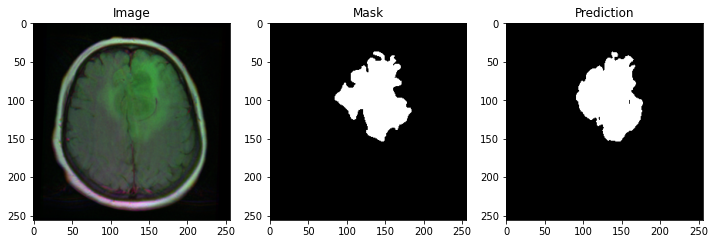

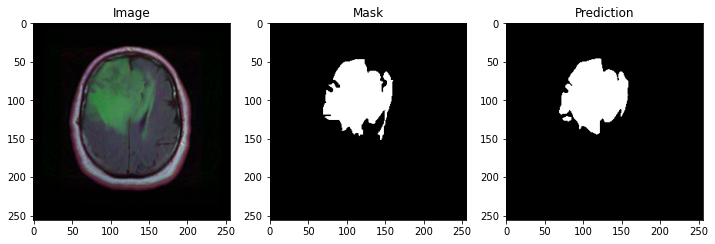

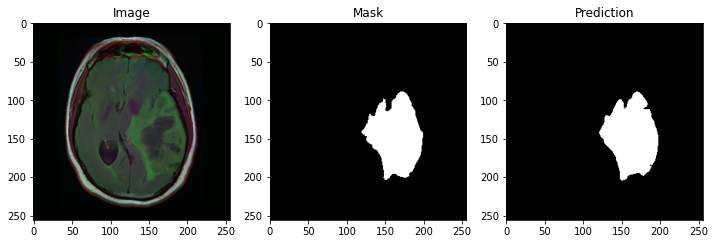

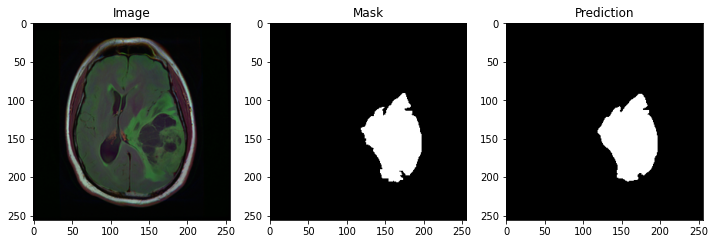

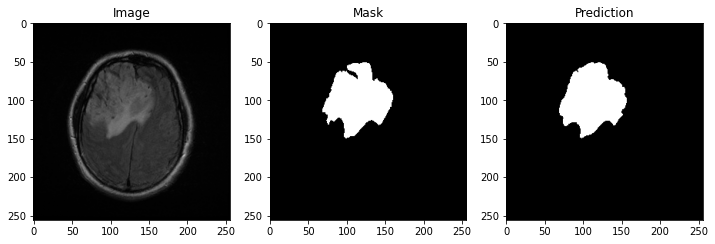

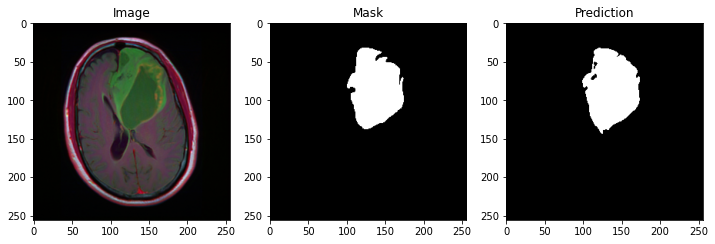

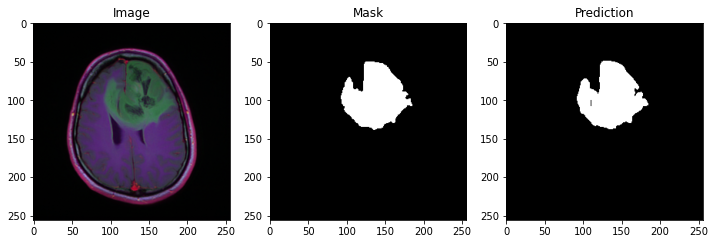

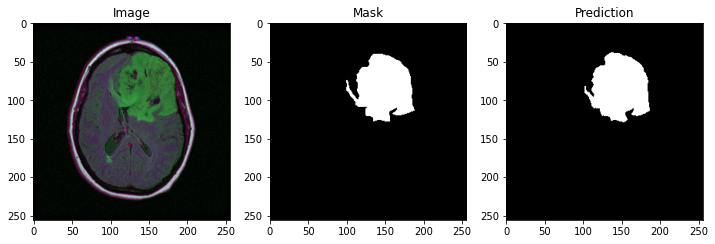

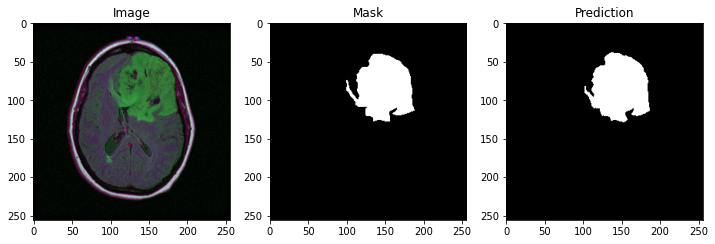

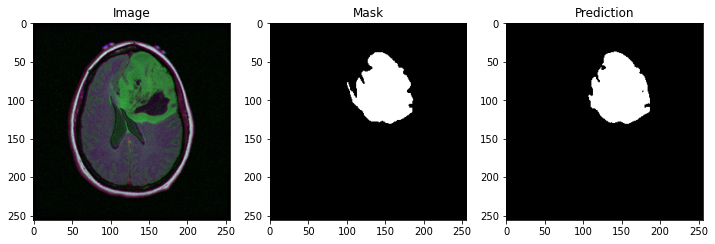

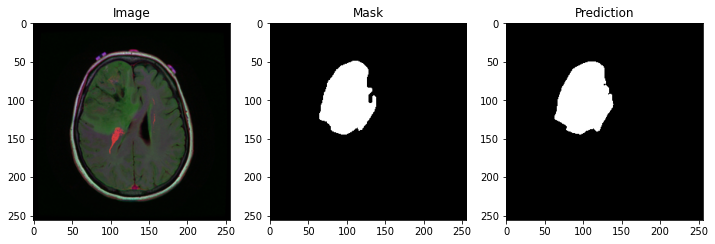

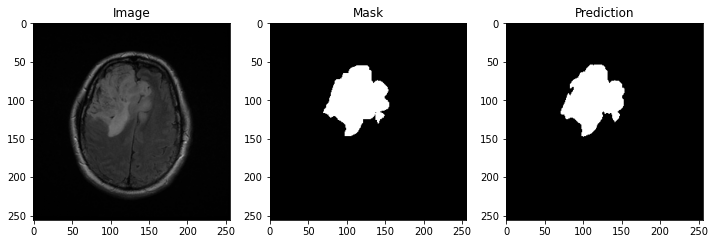

In [28]:
for top_score in sorted(scores)[-1:-15:-1]:
    index = scores.index(top_score)
    img = cv2.imread(test_with_abnormality['image'].iloc[index])
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred)
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(cv2.imread(test_with_abnormality['mask'].iloc[index]))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.where(pred>.5, 1., 0.), cmap='gray')
    plt.title('Prediction')
    plt.show()